In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pybullet_envs
import numpy as np
import torch
import torch.nn as nn
import os
import pickle
import xarray as xr
import matplotlib.pyplot as plt
import copy
import pybullet_envs
import panda_gym
import collections

from seagul.rl.ars.ars_zoo import ARSZooAgent
from seagul.mesh import mdim_div_stable, mesh_dim, mesh_find_target_d, dict_to_array, DualRewardDiv, mdim_safe_stable_nolen, cdim_safe_stable_nolen
from seagul.zoo3_utils import do_rollout_stable, load_zoo_agent

torch.set_default_dtype(torch.float32)

import seaborn as sns
import matplotlib
sns.set_theme()
sns.set_context("paper", font_scale=2.5,  rc={"lines.linewidth": 2.5})





#env_name = 'HalfCheetahBulletEnv-v0'
#algo = 'ppo'

algo = 'tqc'

# env_name = 'FetchPickAndPlace-v1'
# env, model = load_zoo_agent(env_name, algo, render=False)


env_name = "PandaReach-v1"
env1, model1 = load_zoo_agent(env_name, algo)

env_name = "FetchReach-v1"
env2, model2 = load_zoo_agent(env_name, algo)

# env_name = "HalfCheetahBulletEnv-v0"
# env, model = load_zoo_agent(env_name, algo, render=False, env_kwargs={"render":False})

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/FetchReach-v1_1/FetchReach-v1
running build_ext
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}


m: 0.967026186262671, c:5.025685102665477, mc:2.996355644464074, rl:-3.3098180294036865
-1.8116402626037598
-1.498177822232037
[-0.18116403]
m: 0.6682236426533994, c:6.025685102665478, mc:3.3469543726594386, v1:1.9130696014302797, v2:1.9565348007151397
-3.7000909447669983
-1.6734771863297193
[-0.3700091]


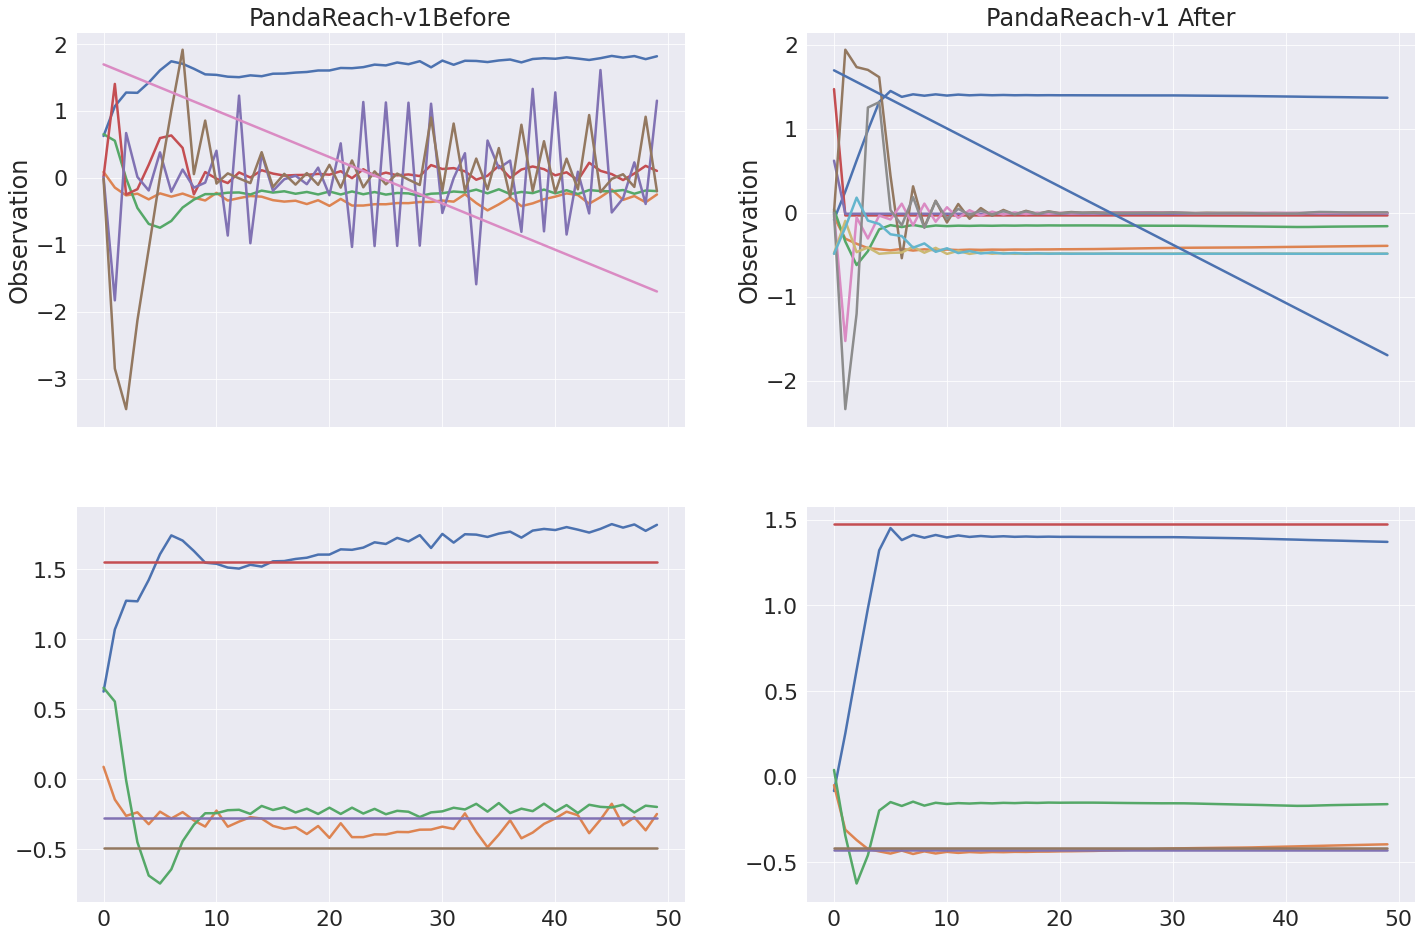

In [3]:
from seagul.mesh import variation_dim
from seagul.mesh import DualRewardLin

def mdim_avg(o,a,r):
    m,c,_,_ = mesh_dim(o)
    return -(m+c)/2

a1 = 10
b1 = .5
lin_rew = DualRewardLin(mdim_avg, a1, b1)

fig, ((ax1o, ax2o), (ax1r, ax2r)) = plt.subplots(2, 2, figsize=(24,16), sharex=True)
seed = int(np.random.randint(1,2**32-2))

o,a,r,i = do_rollout_stable(env1, model1, render=False,seed=seed);

if type(o[0]) == collections.OrderedDict:
    o,ach,des = dict_to_array(o)


#plt.figure(figsize=(16,10))
ax1o.plot(o);
ax1o.set_title(env_name + "Before")
ax1o.set_ylabel('Observation')

ax1r.plot(ach);
ax1r.plot(des);


m,c,_,_ = mesh_dim(o)
v1 = variation_dim(o,1)
v2 = variation_dim(o,2)

rl = lin_rew(o,a,r)

print(f"m: {m}, c:{c}, mc:{(m+c)/2}, rl:{sum(rl)}")
# ax1r.set_xlabel('Time Ticks')
# ax1r.set_ylabel('Goal')
print(a1*sum(r)[0])
print(b1*mdim_avg(o,a,r))

print(sum(r))



o,a,r,i = do_rollout_stable(env2, model2, render=False,seed=seed);

if type(o[0]) == collections.OrderedDict:
    o,ach,des = dict_to_array(o)

#plt.figure(figsize=(16,10))
ax2o.plot(o);
ax2o.set_title(env_name + " After")
ax2o.set_ylabel('Observation')

ax2r.plot(ach);
ax2r.plot(des);


m,c,_,_ = mesh_dim(o)
v1 = variation_dim(o,1)
v2 = variation_dim(o,2)
print(f"m: {m}, c:{c}, mc:{(m+c)/2}, v1:{v1}, v2:{v2}")
print(a1*sum(r)[0])
print(b1*mdim_avg(o,a,r))

# ax2r.set_xlabel('Time Ticks')
# ax2r.set_ylabel('Goal')

print(sum(r))
#print(sum(fn(o, a, r)))

In [ ]:
# o,a,r,i = do_rollout_stable(env, model, render=False);

# if type(o[0]) == collections.OrderedDict:
#     o,ach,des = dict_to_array(o)


# #plt.figure(figsize=(16,10))
# plt.figure()
# plt.plot(o);
# plt.title(env_name)
# plt.xlabel('Time Ticks')
# plt.ylabel('Observation')
# plt.figure()

# plt.plot(ach);
# plt.plot(des);

# print(sum(r))
# #print(sum(fn(o, a, r)))


#mdim, cdim, m,d = mesh_dim(o[200:], upper_size_ratio=1.0, lower_size_ratio=0.0)
#dcrit = mesh_find_target_d(o)

# plt.loglog(d,m,'x-')
# plt.xlabel('d')
# plt.ylabel('m')

# print(mdim)
# print(cdim)
# print(dcrit)

In [44]:
from seagul.mesh import adim_safe_stable_nolen, DualRewardLin, DualRewardProd

prod = DualRewardProd(adim_safe_stable_nolen)
lin = DualRewardLin(adim_safe_stable_nolen, 10, .5)

env_name = "PandaReach-v1"
env, model = load_zoo_agent(env_name, algo)

old_model = model
lin_rew = DualRewardLin(adim_safe_stable_nolen, a1, b1)
new_agent = ARSZooAgent(env_name, algo, seed=1, n_workers=24, n_delta=72, postprocessor=prod, step_schedule=[0.02, 0.002], exp_schedule=[0.02, 0.002], epoch_seed=True)

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1Loading running average

with params: {'norm_obs': True, 'norm_reward': True}
/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1Loading running average
with params: {'norm_obs': True, 'norm_reward': True}

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1Loading running averageLoading running average
with params: {'norm_obs': True, 'norm_reward': True}


with params: {'norm_obs': True, 'norm_reward': True}
/home/

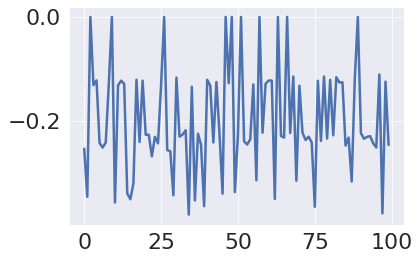

In [45]:
new_agent.learn(100);
plt.plot(new_agent.raw_rew_hist)

[-0.36232805]
0.8596345499663052
[-0.36232805]
0.679566299024558


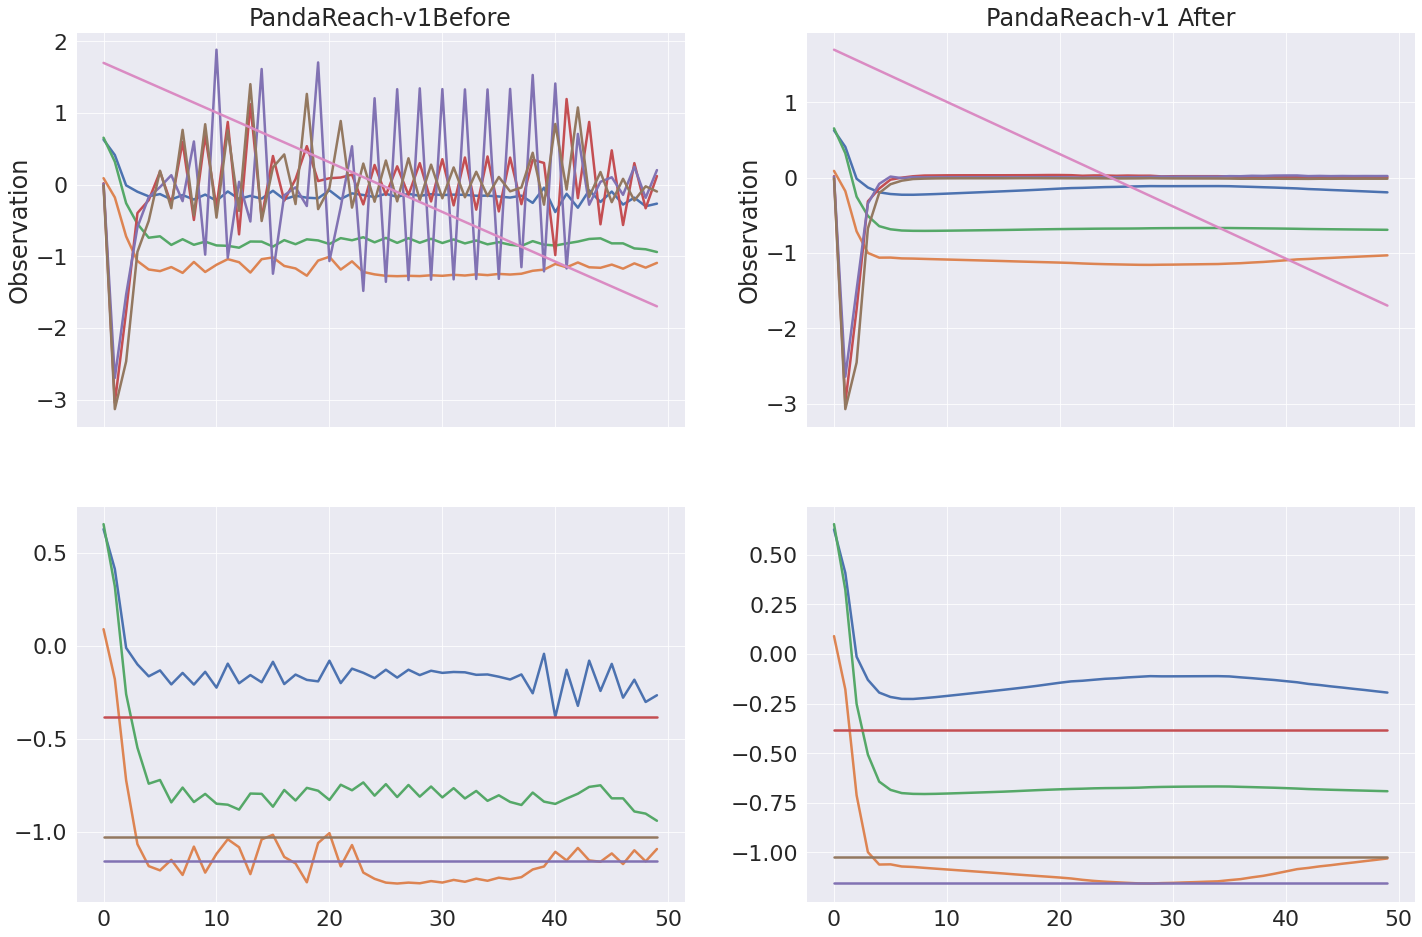

In [51]:
fig, ((ax1o, ax2o), (ax1r, ax2r)) = plt.subplots(2, 2, figsize=(24,16), sharex=True)
seed = int(np.random.randint(1,2**32-2))

o,a,r,i = do_rollout_stable(env, old_model, render=False,seed=seed);

if type(o[0]) == collections.OrderedDict:
    o,ach,des = dict_to_array(o)


#plt.figure(figsize=(16,10))
ax1o.plot(o);
ax1o.set_title(env_name + "Before")
ax1o.set_ylabel('Observation')

ax1r.plot(ach);
ax1r.plot(des);

# ax1r.set_xlabel('Time Ticks')
# ax1r.set_ylabel('Goal')

print(sum(r))
print(adim_safe_stable_nolen(o,a,r))



o,a,r,i = do_rollout_stable(env, new_agent.model, render=False,seed=seed);

if type(o[0]) == collections.OrderedDict:
    o,ach,des = dict_to_array(o)

#plt.figure(figsize=(16,10))
ax2o.plot(o);
ax2o.set_title(env_name + " After")
ax2o.set_ylabel('Observation')

ax2r.plot(ach);
ax2r.plot(des);

# ax2r.set_xlabel('Time Ticks')
# ax2r.set_ylabel('Goal')

print(sum(r))
print(adim_safe_stable_nolen(o,a,r))

#print(sum(fn(o, a, r)))

[-0.5434921]


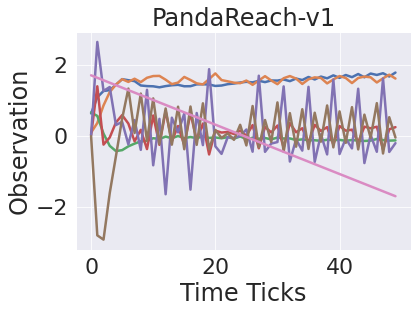

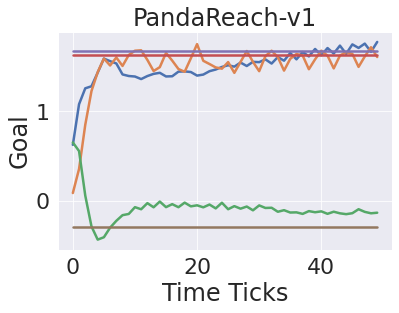

In [6]:
plt.plot(ach);
plt.plot(des);

plt.title(env_name)
plt.xlabel('Time Ticks')
plt.ylabel('Goal')

print(sum(r))
#print(sum(fn(o, a, r)))

In [ ]:
env, old_model = load_zoo_agent(env_name, algo)

model_list = [old_model, new_agent.model]
num_runs = 10

for model in model_list:
    mdims = xr.DataArray(np.zeros((num_runs)))
    cdims = xr.DataArray(np.zeros((num_runs)))
    rews =  xr.DataArray(np.zeros((num_runs)))

    for j in range(num_runs):
        odict,a,r,l = do_rollout_stable(env, model)
        
        o_list = []
        ach_list = []
        des_list = []
        for thing in odict:
            o_list.append(thing['observation'])
            ach_list.append(thing['achieved_goal'])
            des_list.append(thing['desired_goal'])
    
        o = np.stack(o_list).squeeze()
        ach = np.stack(ach_list).squeeze()
        des = np.stack(des_list).squeeze()

        
        o_norm = o
        #o_norm  = o_norm[200:]
        rews[j] = np.sum(r)
        try:
            mdims[j], cdims[j], _, _ = mesh_dim(o_norm)
        except:
            mdims[j] = np.nan
            cdims[j] = np.nan
    print("mesh dimension")
    print(mdims.data)
    mean = mdims.mean().item()
    std = mdims.std().item()
    print(f"mean: {mean}, std: {std}")
    
    print("c dimension")
    print(cdims.data)
    mean = cdims.mean().item()
    std = cdims.std().item()
    print(f"mean: {mean}, std: {std}")

    print("rewards")
    print(rews.data)
    mean = rews.mean().item()
    std = rews.std().item()
    print(f"mean: {mean}, std: {std}")
    print();print()

In [ ]:
from ray import tune

def training_function(config):
    import pybullet_envs

    train, env_name, algo = config["train"], config["env_name"], config["algo"]
    env, model = load_zoo_agent(env_name, algo)
    
    if train:
        new_agent = ARSZooAgent(env_name, algo, n_workers=24, n_delta=64, postprocessor=mdim_div_stable, step_schedule=[0.05, 0.005],  exp_schedule=[0.05, 0.005])
        new_agent.learn(100) 
    
    o,a,r,l = do_rollout_stable(env, model)
    o_norm = env.normalize_obs(o).squeeze()
    o_norm  = o_norm[200:]
    rew = np.sum(r)
    
    try:
        mdim, _, _, _ = mesh_dim(o_norm)
    except:
        mdim = np.nan

    tune.report(mdim=mdim, reward=rew)


analysis = tune.run(
    training_function,
    config={
        "train" : tune.grid_search([False, True]),
        "env_name": tune.grid_search(["Walker2DBulletEnv-v0","HalfCheetahBulletEnv-v0","HopperBulletEnv-v0"]),
        "algo": tune.grid_search(['ppo', 'a2c'])
    })

print("Best config: ", analysis.get_best_config(
    metric="mdim", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

In [ ]:
import pandas as pd

rd = analysis.results_df.to_csv('test.csv')